✅ CSV guardado: resultados_20250702_210346.csv


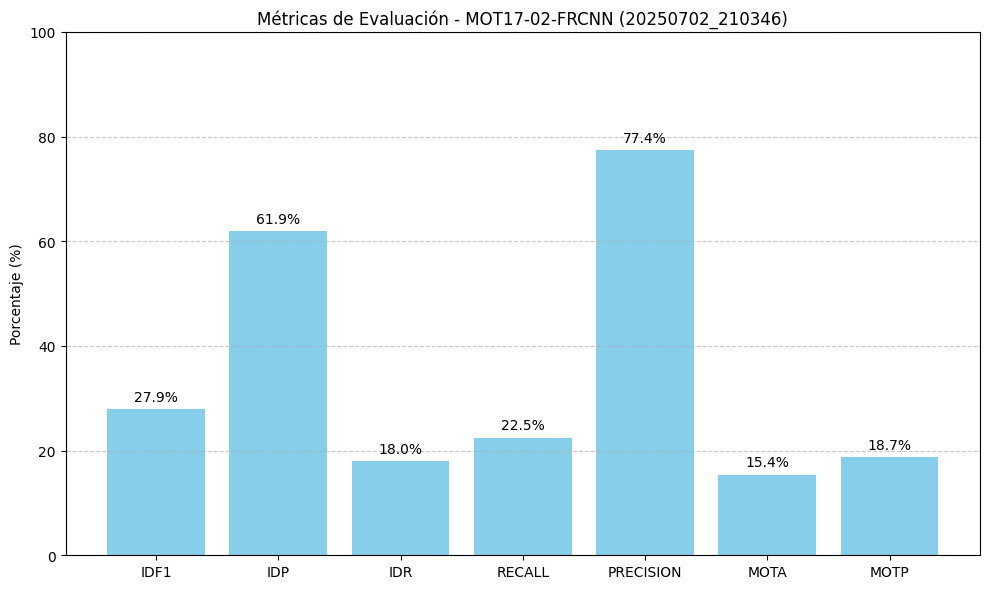

✅ Gráfico guardado: resultados_20250702_210346.png


In [2]:
import motmetrics as mm
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
from collections.abc import Mapping


# === ARCHIVOS DE ENTRADA ===
gt_file = 'C:/Users/jpdeleon/Utec/MOT/MOT17/train/MOT17-02-FRCNN/gt/gt.txt'
res_file = 'C:/Users/jpdeleon/Utec/MOT/MOT17/motchallenge_output.txt'

# === GENERAR TIMESTAMP PARA ARCHIVOS ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_path = f'resultados_{timestamp}.csv'
png_path = f'resultados_{timestamp}.png'

# === LEER GT ===
gt = pd.read_csv(gt_file, header=None)
gt.columns = ['FrameId', 'Id', 'X', 'Y', 'W', 'H', 'Conf', 'Class', 'Vis']
gt = gt[gt['Class'] == 1]  # Solo personas

# === LEER RESULTADOS DEL TRACKER ===
res = pd.read_csv(res_file, header=None)
res.columns = ['FrameId', 'Id', 'X', 'Y', 'W', 'H', 'Conf', 'Unk1', 'Unk2', 'Unk3']

# === EVALUACIÓN MOT METRICS ===
acc = mm.MOTAccumulator(auto_id=True)

for frame in sorted(gt['FrameId'].unique()):
    gt_frame = gt[gt['FrameId'] == frame]
    res_frame = res[res['FrameId'] == frame]

    gt_boxes = list(zip(gt_frame['X'], gt_frame['Y'], gt_frame['W'], gt_frame['H']))
    res_boxes = list(zip(res_frame['X'], res_frame['Y'], res_frame['W'], res_frame['H']))

    # Calcular matriz de distancias IoU (máximo 0.5 para considerar match)
    dist = mm.distances.iou_matrix(gt_boxes, res_boxes, max_iou=0.5)

    # Actualizar el acumulador con IDs y distancias
    acc.update(gt_frame['Id'].tolist(), res_frame['Id'].tolist(), dist)

# === GENERAR MÉTRICAS Y GUARDAR CSV ===
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=mm.metrics.motchallenge_metrics, name='MOT17-02')
summary_rounded = summary.round(3)
summary_rounded.to_csv(csv_path)
print(f"✅ CSV guardado: {csv_path}")

# === GRAFICAR MÉTRICAS CLAVE ===
metricas_clave = ['idf1', 'idp', 'idr', 'recall', 'precision', 'mota', 'motp']
metricas = summary_rounded.loc['MOT17-02'].reindex(metricas_clave) * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(metricas.index.str.upper(), metricas.values, color='skyblue')
plt.ylabel('Porcentaje (%)')
plt.ylim(0, 100)
plt.title(f'Métricas de Evaluación - MOT17-02-FRCNN ({timestamp})')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(png_path)
plt.show()
print(f"✅ Gráfico guardado: {png_path}")
